In [60]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
import json
import requests
%matplotlib inline

In [61]:
url = 'https://parseapi.back4app.com/classes/NamesList?limit=10000&keys=Name'
headers = {
    'X-Parse-Application-Id': 'zsSkPsDYTc2hmphLjjs9hz2Q3EXmnSxUyXnouj1I',
    'X-Parse-Master-Key': '4LuCXgPPXXO2sU5cXm6WwpwzaKyZpo3Wpj4G4xXK'
}
data = json.loads(requests.get(url, headers=headers).content.decode('utf-8'))

results = data['results']
names = [entry['Name'].lower().strip() for entry in results]

In [62]:
len(names)

6779

In [63]:
# Build vocabulary
chars = sorted(set(''.join(names)))
stoi = {ch: i+1 for i, ch in enumerate(chars)}
stoi['.'] = 0
itos = {i: ch for ch, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [64]:
# Encode dataset
block_size = 3
X, Y = [], []
for name in names:
    context = [0] * block_size  # padding
    for ch in name + '.':
        ix = stoi[ch]
        X.append(context.copy())
        Y.append(ix)
        context = context[1:] + [ix]
X = torch.tensor(X)
Y = torch.tensor(Y)


In [65]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([46971, 3]), torch.int64, torch.Size([46971]), torch.int64)

In [66]:
# Build the dataset
block_size = 3

def build_dataset(names):  
  X, Y = [], []
  for name in names:
    context = [0] * block_size
    for ch in name + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(names)
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))

Xtr, Ytr = build_dataset(names[:n1])
Xdev, Ydev = build_dataset(names[n1:n2])
Xte, Yte = build_dataset(names[n2:])

torch.Size([37597, 3]) torch.Size([37597])
torch.Size([4663, 3]) torch.Size([4663])
torch.Size([4711, 3]) torch.Size([4711])


In [67]:
Xtr.shape, Ytr.shape

(torch.Size([37597, 3]), torch.Size([37597]))

In [68]:
g = torch.Generator().manual_seed(234123)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [69]:
sum(p.nelement() for p in parameters)

11897

In [70]:
for p in parameters:
  p.requires_grad = True

In [71]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lri = []
lossi = []
stepi = []

In [72]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  stepi.append(i)
  lossi.append(loss.log10().item())

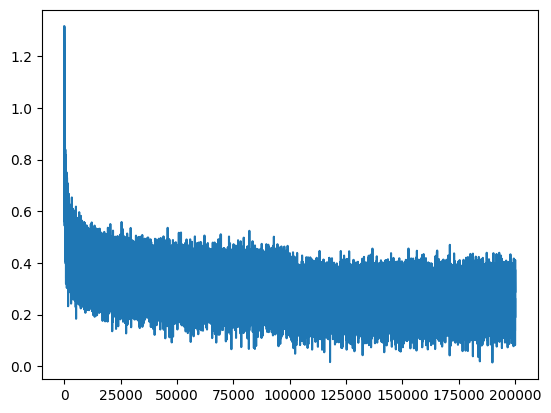

In [73]:
plt.plot(stepi, lossi)

In [74]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.8605, grad_fn=<NllLossBackward0>)

In [75]:
emb = C[Xdev] 
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1879, grad_fn=<NllLossBackward0>)

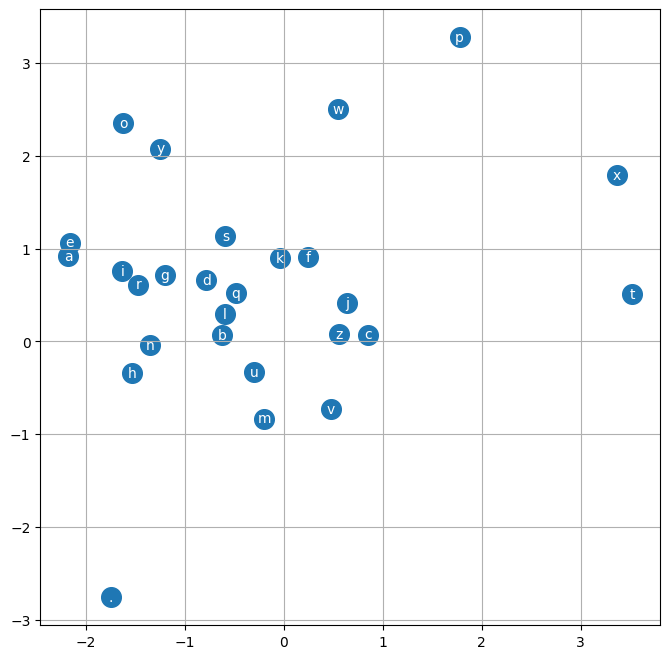

In [76]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [77]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [78]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size
    while True:
      emb = C[torch.tensor([context])]
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

eria.
gry.
justeven.
hey.
lorethrn.
endra.
grade.
edie.
ille.
poren.
edellean.
narle.
tyron.
karin.
shervis.
hilie.
trickette.
kennie.
conuormand.
ruy.
